VAEs dynamiques : https://arxiv.org/abs/2008.12595

# Training Deep Kalman Filter

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# from tests.unit_tests import test_brick_1, test_brick_2, test_brick_3, test_brick_4, test_brick_5, test_brick_6
# from libs.dkf import DeepKalmanFilter, loss_function

In [2]:
def seed_everything(seed=42):
    """
    Set seed for reproducibility.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed for reproducibility
seed_everything(42)

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

print(f"Using {device}")

torch.set_default_dtype(torch.float64)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using cuda
GPU Name: NVIDIA GeForce RTX 3080
Total GPU Memory: 9.8 GB


# Modèle

### Structure SSM (Single State Model pour variables latentes + VAE pour observations):

- $z_t$ variables latentes forment une chaîne de Markov, transition $p(z_t \vert z_{t-1})$
- $x_t$ observations, modèle $p_{\theta_x}(x_t \vert z_t)$
- NB : pas de commande/input $u_t$ ici

### Deep Kalman Filter :

\begin{align}
p_{\theta_z}(z_t \vert z_{t-1}) &= \mathcal{N}(z_t \vert \mu_{\theta_z}(z_{t-1}), \text{diag}(\sigma_{\theta_z}^{2}(z_{t-1}))) \\
d_z(z_{t-1}) &= [ \mu_{\theta_z}(z_{t-1}), \sigma_{\theta_z}(z_{t-1}) ] \\
p_{\theta_x}(x_t \vert z_{t}) &= \mathcal{N}(x_t \vert \mu_{\theta_x}(z_{t}), \text{diag}(\sigma_{\theta_x}^{2}(z_{t}))) \\
d_x(z_{t}) &= [ \mu_{\theta_x}(z_{t}), \sigma_{\theta_x}(z_{t}) ] \\
\end{align}

où $d_x, d_z$ sont des réseaux.

### Modèle inférence

Le "true posterior" s'écrit :
\begin{align}
p_{\theta}(z_{1:T} \vert x_{1:T}) &= \prod_{t=1}^T p_{\theta} (z_t \vert z_{1:t-1}, x_{1:T} ) \\
&= \prod_{t=1}^T p_{\theta} (z_t \vert z_{t-1}, x_{t:T} )
\end{align}

où la première écriture est l'application de la chain rule, et la deuxième est un résultat de D-séparation (latentes à dépendance Markovienne).

On choisit comme approximation du posterior (=encodeur) une formulation calquée sur le vrai posterior :

\begin{align}
q_{\phi}(z_{1:T} \vert x_{1:T}) &= \prod_{t=1}^T q_{\phi} (z_{t} \vert z_{t-1}, x_{t:T})
\end{align}

On voit que l'inférence prend en compte les observations futures $x_{t:T}$ (comme le Kalman smoother par exemple)

# Implémentation de l'inférence

- **backward RNN** (dans les faits, un LSTM) pour encoder les $x_{t:T}$ par les hidden states $h_t$ : 

\begin{align}
h_t = \text{LSTM}(h_{t+1}, x_t)
\end{align}

- **combiner** (réseau MLP) pour aggréger $h_t$ et $z_{t-1}

\begin{align}
g_t = \text{Combiner}(h_t, z_{t-1})
\end{align}

- **Encoder** (réseau MLP) pour inférer les paramètres du posterior:

\begin{align}
e_z(g_t) &= [ \mu_\phi(g_t), \sigma_\phi(g_t)] \\
q_\phi(z_t \vert g_t) &= \mathcal{N}(z_t \vert \mu_{\phi}(g_t), \text{diag}(\sigma_\phi^2(g_t)))
\end{align}

NB : il existe d'autres formulations du posterior approximé $q_\phi$, qui peuvent faire intervenir un forward LSTM.

# Training

Le modèle s'entraîne en maximisant un ELBO, dont la formulation générique se simplifie dans le cas du DKF en :

\begin{align}
\mathcal{L}(\theta, \phi; X) &= \sum_{t=1}^T \mathbb{E}_{q_\phi(z_t \vert x_{1:T})} \log(p_{\theta_x}(x_t \vert z_t)) -
\sum_{t=1}^T \mathbb{E}_{q_\phi(z_{t-1} \vert x_{1:T})} \text{D}_{\text{KL}} \left[ q_\phi(z_t \vert z_{-1}, x_{t:T}) \vert\vert 
p_{\theta_z}(z_t \vert z_{t-1}) \right]
\end{align}

Les deux termes s'explicitent de la façon suivante (avec $D$ dimension de l'espace des observations) :

\begin{align}
p_{\theta_x}(x_t \vert z_t) &= \mathcal{N}(x_t \vert \mu_{\theta_x}(z_t), \text{diag}(\sigma_{\theta_x}^2(z_t))) \\
\log{p_{\theta_x}(x_t \vert z_t)} &= -\frac{D}{2} \log{2\pi} - \frac{1}{2}\log{\vert \text{diag}(\sigma_{\theta_x}^2(z_t)) \vert} - 
\frac{1}{2} \left[ (x_t - \mu_{\theta_x}(z_t))^T (\text{diag}(\sigma_{\theta_x}^2(z_t)))^{-1} (x_t - \mu_{\theta_x}(z_t)) \right] \\
&= \frac{1}{2} \left( \sum_{i=1}^D \log{\sigma_{\theta_x}^2(z_t)}\vert_{i} + (x_t - \mu_{\theta_x}(z_t))^T \text{diag} \frac{1}{\sigma_{\theta_x}^2(z_t)} (x_t - \mu_{\theta_x}(z_t)) \right)
\end{align}

Et la KL entre les deux Gaussiennes:

\begin{align}
q_\phi(z_t \vert z_{t-1}, x_{t:T}) &= \mathcal{N}(z_t \vert \mu_{\phi}(g_t), \text{diag}(\sigma_\phi^2(g_t))) \\
p_{\theta_z}(z_t \vert z_{t-1}) &= \mathcal{N}(z_t \vert \mu_{\theta_z}(z_{t-1}), \text{diag}(\sigma_{\theta_z}^{2}(z_{t-1}))) \\
\end{align}

a une close form (avec $Z$ dimension de l'espace latent):

\begin{align}
\text{D}_{\text{KL}}(q_\phi \vert\vert p_{\theta_z}) &= \frac{1}{2} \left[ \text{Tr}(\text{diag}(\sigma_{\theta_z}^{2})^{-1} \text{diag}(\sigma_\phi^2) ) + (\mu_{\theta_z} - \mu_\phi)^T (\text{diag}(\sigma_{\theta_z}^{2})^{-1}) (\mu_{\theta_z} - \mu_\phi) +
\log{\frac{\vert \text{diag}(\sigma_{\theta_z}^{2})\vert}{\vert \text{diag}(\sigma_\phi^2) \vert} } \right] \\
&= \frac{1}{2}\left[ \sum_{i=1}^Z \log{\sigma_{\theta_z}^{2}}\vert_i - \sum_{i=1}^Z \log{\sigma_{\phi}^{2}}\vert_i +
 (\mu_{\theta_z} - \mu_\phi)^T \text{diag}(\frac{1}{\sigma_{\theta_z}^{2}}) (\mu_{\theta_z} - \mu_\phi) + \sum_{i=1}^D \frac{\sigma_{\phi}^{2}\vert_i} {\sigma_{\theta_z}^{2}\vert_i} - Z 
\right]
\end{align}

In [ ]:
#--- brick 1 : backward LSTM -----------------------------

class BackwardLSTM(nn.Module):
    """
    Backward LSTM module.
    """
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(BackwardLSTM, self).__init__()
        
        self.input_size = input_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(
            input_size,   # dimension of the observation space
            hidden_size,  # dimension of the hidden state of the LSTM network
            num_layers=num_layers, # number of layers of the LSTM network
            batch_first=False, # using the default PyTorch LSTM implementation, expecting input shape (seq_len, batch, input_size)
            bidirectional=False # unidirectional LSTM to start with
            )

    def forward(self, x):
        # Reverse the input sequence - axis 0 is the time axis here
        x_reversed = torch.flip(x, [0])
        # Pass through LSTM
        # using initial hidden state and cell state as zeros
        out, _ = self.lstm(x_reversed)
        # Reverse the output sequence
        out_reversed = torch.flip(out, [0])
        # return output shape (seq_len, batch, hidden_size)
        
        return out_reversed

Data Generation for Time Series Forecasting

In [5]:
def generate_time_series(batch_size, n_steps, noise=0.05):
    """Utility function to generate time series data.

    Args:
        batch_size (int): number of time series to generate (btach size)
        n_steps (_type_): length of each time series
    """
    
    f1,f2,o1,o2 = np.random.rand(4, batch_size, 1)  # return 4 values for each time series
    time = np.linspace(0, 1, n_steps)  # time vector
    
    series = 0.8 * np.sin((time - o1) * (f1 * 10 + 10)) # first sine wave
    series += 0.2 * np.sin((time - o1) * (f1 * 20 + 20)) # second sine wave
    series += noise * (np.random.randn(batch_size, n_steps) - 0.5)  # add noise
    
    return series

In [6]:
n_steps = 50
n_series = 10000
s = generate_time_series(n_series, n_steps+1)

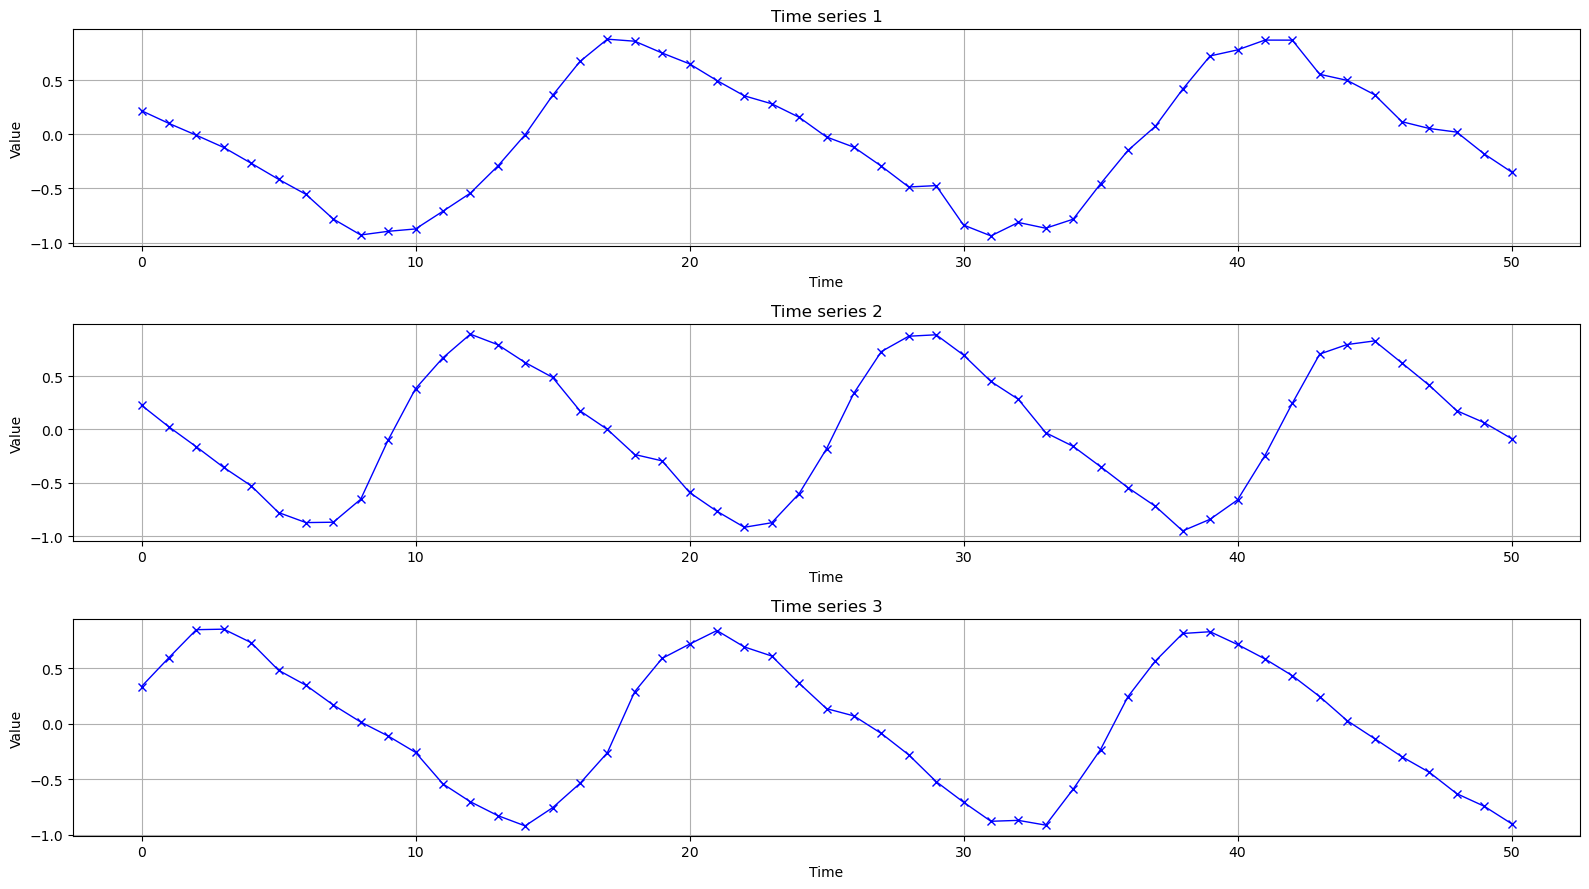

In [7]:
N = 3
fig, axs = plt.subplots(N, 1, figsize=(16, 3 * N))
for i in range(N):
    axs[i].plot(s[i], color='blue', marker="x", linewidth=1)
    axs[i].set_title(f"Time series {i+1}")
    axs[i].set_xlabel("Time")
    axs[i].set_ylabel("Value")
    axs[i].grid(True)
plt.tight_layout()
plt.show()

In [8]:
cutoff = int(0.8 * n_series)

X_train, y_train = s[:cutoff,:n_steps], s[:cutoff,-1]
X_valid, y_valid = s[cutoff:,:n_steps], s[cutoff:,-1]

In [9]:
# form datasets, dataloaders, etc

BATCH_SIZE = 8192

from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X).to(device)
        self.y = torch.tensor(y).to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
valid_dataset = TimeSeriesDataset(X_valid, y_valid)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

Baseline metrics

In [10]:
# Predicted value is the last value of the time series

y_pred = X_valid[:,-1]
print(f"{np.mean(np.sqrt((y_valid - y_pred) ** 2)):.4f} RMSE")

0.1769 RMSE


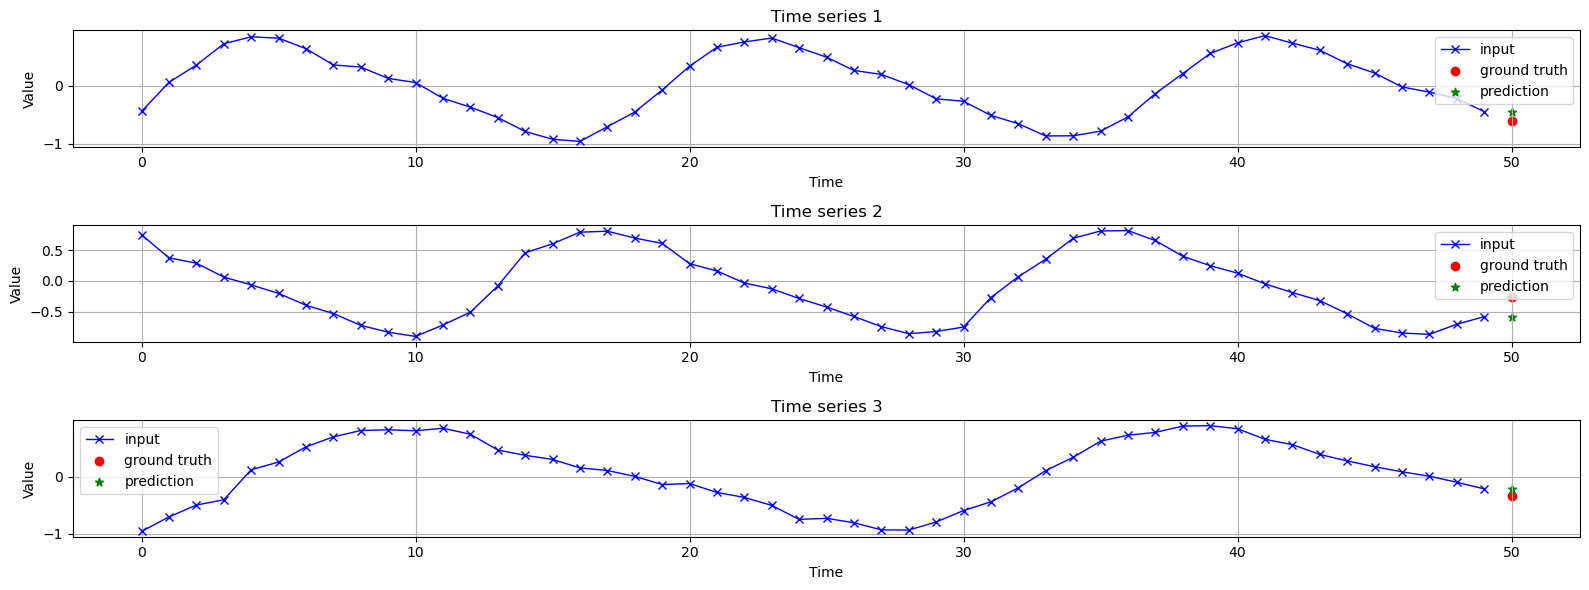

In [11]:
N = 3
fig, axs = plt.subplots(N, 1, figsize=(16, 2 * N))
for i in range(N):
    input = torch.tensor(X_valid[i], device=device)
    target = torch.tensor(y_valid[i], device=device)
    output = y_pred[i]
    target = target.cpu().detach().numpy()
    axs[i].plot(input.cpu().detach().numpy(), color='blue', marker="x", linewidth=1, label="input")
    axs[i].scatter(n_steps, target, color='red', marker="o", linewidth=1, label="ground truth")
    axs[i].scatter(n_steps, output, color='green', marker="*", linewidth=1, label="prediction")
    axs[i].set_title(f"Time series {i+1}")
    axs[i].set_xlabel("Time")
    axs[i].set_ylabel("Value")
    axs[i].legend()
    axs[i].grid(True)
plt.tight_layout()
plt.show()

### Training DKF

In [20]:
xdim = 1
latent_dim = 16
h_dim = 16
combiner_dim = 8

In [21]:
dkf = DeepKalmanFilter(
    input_dim = xdim,
    latent_dim = latent_dim,
    hidden_dim = h_dim,
    combiner_dim = combiner_dim,
    num_layers = 1,
    device=device
).to(device)

print(dkf)

DeepKalmanFilter(input_dim=1, latent_dim=16, hidden_dim=16, combiner_dim=8, inter_dim=16)
BackwardLSTM(
  (lstm): LSTM(1, 16)
)
CombinerMLP(
  (activation_fn): Tanh()
  (mlp): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=8, bias=True)
  )
)
EncoderMLP(
  (activation_fn): Tanh()
  (mlp): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=32, bias=True)
  )
)
LatentSpaceTransitionMLP(
  (activation_fn): Tanh()
  (mlp): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=32, bias=True)
  )
)
DecoderMLP(
  (activation_fn): Tanh()
  (mlp): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=2, bias=True)
  )
)
Sampler()


In [22]:
optimizer = torch.optim.Adam(dkf.parameters(), lr=5e-4)
loss_fn = loss_function

In [23]:
# Training step : perform training for one epoch

def train_step(model, optimizer, criterion, train_loader=train_loader, device=device):
    ### training step
    model.train()
    optimizer.zero_grad()
    ### loop on training data
    rec_loss = 0
    kl_loss = 0
    epoch_loss = 0
    
    for input, _ in train_loader:
        input = input.to(device).unsqueeze(-1)  # add a feature dimension
        input = input.permute(1, 0, 2)  # permute to (seq_len, batch_size, input_dim)

        _, mu_x_s, logvar_x_s, mu_z_s, logvar_z_s, mu_z_transition_s, logvar_z_transition_s = model(input)
        
        rec_loss, kl_loss, total_loss = criterion(input, mu_x_s, logvar_x_s, mu_z_s, logvar_z_s, mu_z_transition_s, logvar_z_transition_s)
        
        total_loss.backward()
        optimizer.step()
              
        rec_loss += rec_loss.item()
        kl_loss += kl_loss.item()
        epoch_loss += total_loss.item()
        
    epoch_loss /= len(train_loader)
    rec_loss /= len(train_loader)
    kl_loss /= len(train_loader)
    
    return rec_loss, kl_loss, epoch_loss

In [24]:
num_epochs = 1000

In [25]:
rec_losses = []
kl_losses = []
epoch_losses = []

for i in range(num_epochs):
    
    # run the training step
    rec_loss, kl_loss, epoch_loss = train_step(dkf, optimizer, loss_fn)
    # log results
    rec_losses.append(rec_loss)
    kl_losses.append(kl_loss)
    epoch_losses.append(epoch_loss)
    # Print the losses for this epoch
    if (i+1) % 10 == 0:
        print(f"Epoch {i+1:>5}/{num_epochs} - Rec Loss: {rec_loss:.4e}, KL Loss: {kl_loss:.4e}, Total Loss: {epoch_loss:.4e}")

Epoch    10/1000 - Rec Loss: 5.5832e-01, KL Loss: 3.6693e+01, Total Loss: 1.8626e+01
Epoch    20/1000 - Rec Loss: 5.0727e-01, KL Loss: 3.5750e+01, Total Loss: 1.8129e+01
Epoch    30/1000 - Rec Loss: 4.6071e-01, KL Loss: 3.5009e+01, Total Loss: 1.7735e+01
Epoch    40/1000 - Rec Loss: 4.2290e-01, KL Loss: 3.4424e+01, Total Loss: 1.7424e+01
Epoch    50/1000 - Rec Loss: 3.8552e-01, KL Loss: 3.3948e+01, Total Loss: 1.7167e+01
Epoch    60/1000 - Rec Loss: 3.5616e-01, KL Loss: 3.3569e+01, Total Loss: 1.6963e+01
Epoch    70/1000 - Rec Loss: 3.2561e-01, KL Loss: 3.3263e+01, Total Loss: 1.6794e+01
Epoch    80/1000 - Rec Loss: 2.9533e-01, KL Loss: 3.3019e+01, Total Loss: 1.6657e+01
Epoch    90/1000 - Rec Loss: 2.6523e-01, KL Loss: 3.2825e+01, Total Loss: 1.6545e+01
Epoch   100/1000 - Rec Loss: 2.3697e-01, KL Loss: 3.2677e+01, Total Loss: 1.6457e+01
Epoch   110/1000 - Rec Loss: 2.1051e-01, KL Loss: 3.2559e+01, Total Loss: 1.6385e+01
Epoch   120/1000 - Rec Loss: 1.8459e-01, KL Loss: 3.2466e+01, Tot

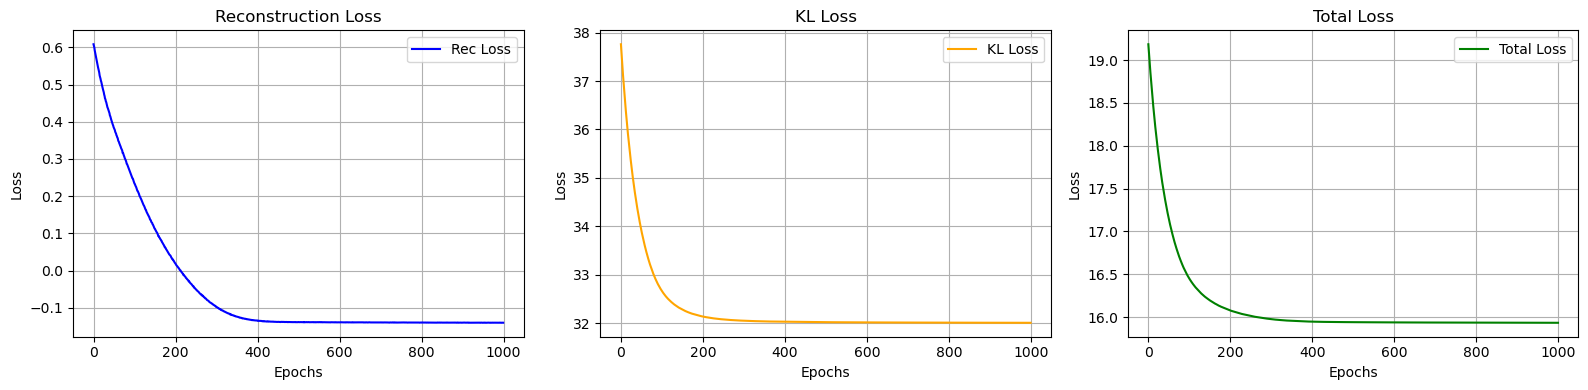

In [26]:
# Plot the losses

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
axs[0].plot(torch.tensor(rec_losses).cpu().detach(), label='Rec Loss', color='blue')
axs[0].set_title('Reconstruction Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid()
axs[1].plot(torch.tensor(kl_losses).cpu().detach(), label='KL Loss', color='orange')
axs[1].set_title('KL Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid()
axs[2].plot(torch.tensor(epoch_losses).cpu().detach(), label='Total Loss', color='green')
axs[2].set_title('Total Loss')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Loss')
axs[2].legend()
axs[2].grid()
plt.tight_layout()
plt.show()

In [ ]:
# def test_step(model, criterion, valid_loader=valid_loader):
#     ### testing step
#     model.eval()
#     epoch_loss = 0
#     with torch.no_grad():
#         for input, target in valid_loader:
#             input = input.to(device).unsqueeze(-1)  # add a feature dimension
#             target = target.to(device).view(-1, 1)
#             output = model(input)
#             loss = criterion(output, target)
#             epoch_loss += loss.item()
#     epoch_loss /= len(valid_loader)
#     return epoch_loss

In [ ]:
# def train_rnn_model(model, num_epochs=20, batch_size=32):
#     print(f"Start training RNN model for {num_epochs} epochs")
#     for i in range(num_epochs):
#         # loop on training data
#         train_step_loss = train_step(model, optimizer, criterion)
#         train_losses.append(train_step_loss)
#         # test step
#         test_step_loss = test_step(model, criterion)
#         valid_losses.append(test_step_loss)
#         print(f"epoch {i+1}/{num_epochs}, training loss = {train_step_loss:.4e}, validation loss = {test_step_loss:.4e}")
#     print("\nTraining finished")
#     return train_losses, valid_losses

In [ ]:
# rnn = RNNModel(
#     input_dim=1,
#     output_dim=1,
#     hidden_dim=64,
#     num_layers=1,
#     batch_first=True,
#     device=device,
#     dtype=dtype
# ).to(device)

# print(rnn)

# lr = 1e-5
# optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)
# criterion = nn.MSELoss()
# train_losses = []
# valid_losses = []
# num_epochs = 50

# train_losses, valid_losses = train_rnn_model(rnn, num_epochs=num_epochs, batch_size=32)

# plt.plot(train_losses, label="train")
# plt.plot(valid_losses, label="valid")
# plt.legend()
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.title("Training and Validation Loss")
# plt.grid()
# plt.show()

In [ ]:
# y_pred = rnn(torch.tensor(X_valid).to(device).unsqueeze(-1))
# y_pred = y_pred.cpu().detach().numpy()

# print(f"\n{np.mean(np.sqrt((y_valid - y_pred) ** 2)):.4f} RMSE")

In [ ]:
# N = 5
# fig, axs = plt.subplots(N, 1, figsize=(16, 3 * N))
# for i in range(N):
#     input = torch.tensor(X_valid[i], device=device).unsqueeze(1).unsqueeze(0)
#     # print(f"input has shape {input.shape}")
#     target = torch.tensor(y_valid[i], device=device).view(-1,1)
#     # print(f"target has shape {target.shape}")
#     output = rnn(input)
#     output = output.cpu().detach().numpy()
#     # print(f"output has shape {output.shape}")
#     target = target.cpu().detach().numpy()
#     axs[i].plot(input.squeeze().cpu().detach().numpy(), color='blue', marker="x", linewidth=1, label="input")
#     axs[i].scatter(n_steps, target, color='red', marker="o", linewidth=1, label="ground truth")
#     axs[i].scatter(n_steps, output, color='green', marker="*", linewidth=1, label="prediction")
#     axs[i].set_title(f"Time series {i+1}")
#     axs[i].set_xlabel("Time")
#     axs[i].set_ylabel("Value")
#     axs[i].legend()
#     axs[i].grid(True)
# plt.tight_layout()
# plt.show()

### Forecast N steps ahead

In [ ]:
# N_AHEAD = 20
# n_series = 50000
# cutoff = int(n_series * 0.8)

# series = generate_time_series(n_series, n_steps + N_AHEAD)

# X_train, y_train = series[:cutoff, :n_steps], series[:cutoff, -N_AHEAD:]
# X_test, y_test = series[cutoff:, :n_steps], series[cutoff:, -N_AHEAD:]

# print(f"X_train shape: {X_train.shape}")
# print(f"y_train shape: {y_train.shape}")    
# print(f"X_test shape: {X_test.shape}")
# print(f"y_test shape: {y_test.shape}")

# train_dataset = TimeSeriesDataset(X_train, y_train)
# test_dataset = TimeSeriesDataset(X_test, y_test)

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [ ]:
# class RNNModelLookAhead(nn.Module):
#     def __init__(self, input_dim, output_dim, hidden_dim, n_ahead=N_AHEAD, num_layers=1, batch_first=True, device=device, dtype=dtype):
#         """Constructor for RNN.

#         Args:
#             input_dim (_type_): dimensionality of the input
#             hidden_dim (_type_): dimensionality of the hidden state
#             n_ahead (_type_, optional): number of time steps to predict. Defaults to N_AHEAD.
#             output_dim (_type_, optional): dimensionality of the output.
#             num_layers (int, optional): number of recurrent layers. Defaults to 1.
#             batch_first (bool, optional): whether batch dim is first or not. Defaults to True.
#                 1. batch_first=True: (batch, seq, feature_dimension)
#                 2. batch_first=False: (seq, batch, feature_dimension)
#             bidirectional (bool, optional): if True, becomes a bidriectional RNN. Defaults to False.
#                 1. bidirectional=True: num_directions=2, (batch, seq, hidden_dim * 2)
#                 2. bidirectional=False: num_directions=1, (batch, seq, hidden_dim)
#             device (_type_, optional): _description_. Defaults to device.
#             dtype (_type_, optional): _description_. Defaults to dtype.
#         """
#         super(RNNModelLookAhead, self).__init__()
        
#         self.input_dim = input_dim
#         self.output_dim = output_dim
#         self.hidden_dim = hidden_dim
#         self.num_layers = num_layers
#         self.batch_first = batch_first
#         self.bidirectional = False
#         self.n_ahead = n_ahead
        
#         self.rnn = nn.RNN(
#             input_size=input_dim,
#             hidden_size=hidden_dim,
#             num_layers=num_layers,
#             batch_first=batch_first,
#             bidirectional=self.bidirectional
#         )
#         self.fc = nn.Linear(hidden_dim, n_ahead*output_dim)
    
#     def forward(self, x):
#         # first, initialize the hidden state
#         h0 = torch.zeros((self.num_layers, x.size(0), self.hidden_dim), requires_grad=True).to(device)
#         # INPUT : x : (batch, sequence_length, input_feature_dimension)
#         x, _ = self.rnn(x, h0) 
#         # OUTPUT: N = 10
# fig, ax  = plt.subplots(N, 1, figsize=(16, 3 * N))
# x_shift = X_test.shape[-1]

# for i in range(N):
#     input = torch.tensor(X_test[i], device=device).unsqueeze(0).unsqueeze(-1)
#     # print(f"input has shape {input.shape}")
#     target = torch.tensor(y_test[i], device=device).view(-1, N_AHEAD, 1)
#     # print(f"target has shape {target.shape}")
#     output = rnn(input)
#     output = output.cpu().detach().numpy()
#     # print(f"output has shape {output.shape}")
#     target = target.cpu().detach().numpy()
    
#     ax[i].plot(input.squeeze().cpu().detach().numpy(), color='blue', marker="x", linewidth=1, label="input")
#     ax[i].plot(np.arange(len(target.squeeze()))+x_shift, target.squeeze(), color='red', marker="o", linewidth=1, label="ground truth")
#     ax[i].plot(np.arange(len(target.squeeze()))+x_shift, output.squeeze(), color='green', marker="*", linewidth=1, label="prediction")
#     ax[i].set_title(f"Time series {i+1}")
#     ax[i].set_xlabel("Time")
#     ax[i].set_ylabel("Value")
#     ax[i].legend()
#     ax[i].grid(True)

# plt.tight_layout()
# plt.show()
#         # - output : (batch, sequence_length, hidden_dimension * num_directions)
#         # - h_n : (num_layers * num_directions, batch, hidden_dimension) (hidden state for last time step)
#         x = self.fc(x[:, -1, :])  # take the last time step
#         x = x.view(-1, self.n_ahead, self.output_dim)
#         # OUTPUT: x : (batch, output_dimension)
#         return x

In [ ]:
# rnn = RNNModelLookAhead(
#     input_dim=1,
#     output_dim=1,
#     n_ahead=N_AHEAD,
#     hidden_dim=128,
#     num_layers=4,
#     batch_first=True,
#     device=device,
#     dtype=dtype
# ).to(device)

# print(rnn)

In [ ]:
# # Test dimensions

# x = torch.randn(32, 50, 1).to(device)
# y = rnn(x)
# print(f"input shape: {x.shape}")
# print(f"output shape: {y.shape}")

In [ ]:
# lr = 1e-5
# optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)
# criterion = nn.MSELoss()
# num_epochs = 50

In [ ]:
# train_losses = []
# valid_losses = []

# print(f"Start training RNN model for {num_epochs} epochs")

# for i in range(num_epochs):
#     # loop on training data
#     rnn.train()
#     optimizer.zero_grad()
#     ### loop on training data
#     epoch_loss = 0
#     for input, target in train_loader:
#         input = input.to(device).unsqueeze(-1)  # add a feature dimension
#         # print(f"input has shape {input.shape}")
#         target = target.to(device).view(-1, N_AHEAD, 1)
#         # print(f"target has shape {target.shape}")
#         output = rnn(input)
#         # print(F"output has shape {output.shape}")
#         loss = criterion(output, target)
#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.item()
#     epoch_loss /= len(train_loader) 
#     train_losses.append(epoch_loss)
    
#     # test step
#     rnn.eval()
#     epoch_loss = 0
#     with torch.no_grad():
#         for input, target in test_loader:
#             input = input.to(device).unsqueeze(-1)  # add a feature dimension
#             target = target.to(device).view(-1, N_AHEAD, 1)
#             output = rnn(input)
#             loss = criterion(output, target)
#             epoch_loss += loss.item()
#     epoch_loss /= len(test_loader)
#     valid_losses.append(epoch_loss)
    
#     # report out
#     print(f"epoch {i+1:>4}/{num_epochs}, training loss = {train_losses[-1]:.4e}, validation loss = {valid_losses[-1]:.4e}")

In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(16, 3))
# ax.plot(train_losses, label="train")
# ax.plot(valid_losses, label="valid")
# ax.legend()
# ax.set_xlabel("Epoch")
# ax.set_xticks(np.arange(0, num_epochs+1, 2))
# ax.set_xticklabels(np.arange(0, num_epochs+1, 2))
# ax.set_ylabel("Loss")
# ax.set_title("Training and Validation Loss")
# ax.grid()
# plt.show()

In [ ]:
# y_pred = rnn(torch.tensor(X_test).to(device).unsqueeze(-1))
# y_pred = y_pred.cpu().detach().numpy().squeeze()
# # print(y_pred.shape)
# # print(y_test.shape)

# print(f"\n{np.mean(np.sqrt((y_test - y_pred) ** 2)):.4f} RMSE")

In [ ]:
# N = 10
# fig, ax  = plt.subplots(N, 1, figsize=(16, 3 * N))
# x_shift = X_test.shape[-1]

# for i in range(N):
#     input = torch.tensor(X_test[i], device=device).unsqueeze(0).unsqueeze(-1)
#     # print(f"input has shape {input.shape}")
#     target = torch.tensor(y_test[i], device=device).view(-1, N_AHEAD, 1)
#     # print(f"target has shape {target.shape}")
#     output = rnn(input)
#     output = output.cpu().detach().numpy()
#     # print(f"output has shape {output.shape}")
#     target = target.cpu().detach().numpy()
    
#     ax[i].plot(input.squeeze().cpu().detach().numpy(), color='blue', marker="x", linewidth=1, label="input")
#     ax[i].plot(np.arange(len(target.squeeze()))+x_shift, target.squeeze(), color='red', marker="o", linewidth=1, label="ground truth")
#     ax[i].plot(np.arange(len(target.squeeze()))+x_shift, output.squeeze(), color='green', marker="*", linewidth=1, label="prediction")
#     ax[i].set_title(f"Time series {i+1}")
#     ax[i].set_xlabel("Time")
#     ax[i].set_ylabel("Value")
#     ax[i].legend()
#     ax[i].grid(True)

# plt.tight_layout()
# plt.show()

### Bidirectionnal RNN

https://www.geeksforgeeks.org/bidirectional-recurrent-neural-network/

https://www.kaggle.com/code/amansherjadakhan/introduction-to-bidirectional-rnn